In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
datadir = 'dataset2'
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  datadir,
  label_mode='categorical',
  validation_split=0.3,
  subset="training",
  seed=1337,
  image_size=(224, 224),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  datadir,
  label_mode='categorical',
  validation_split=0.3,
  subset="validation",
  seed=1337,
  image_size=(224, 224),
  batch_size=batch_size
)

Found 1125 files belonging to 4 classes.
Using 788 files for training.


2022-02-18 17:22:19.885440: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-18 17:22:23.664791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38415 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


Found 1125 files belonging to 4 classes.
Using 337 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'rain', 'shine', 'sunrise']


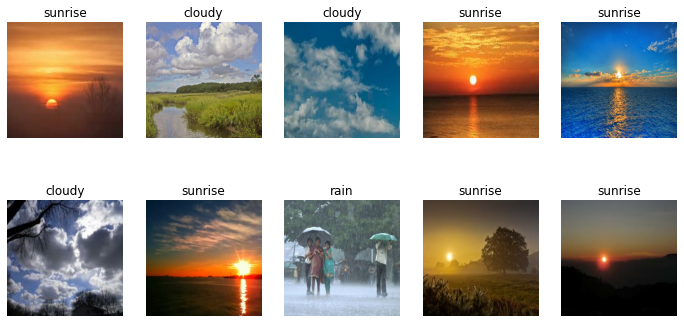

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.figure(figsize=(12, 6))
for images, labels in val_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


In [5]:
AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
from tensorflow.keras.layers import (RandomFlip, RandomRotation, RandomZoom,
                                     RandomContrast, Conv2D, MaxPool2D,
                                     Flatten, Dense, Input)
from tensorflow.keras import Sequential

def build_model(num_classes, augment_data=False, name=None):
  normalization_layer = tf.keras.layers.Rescaling(1./255)

  augmentation_layers = tf.keras.Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(0.5),
    RandomContrast(0.2)
  ])

  VGG16 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=4096, activation='relu'),
    Dense(units=num_classes, activation='softmax')
  ])

  model = Sequential(name=name)
  model.add(Input((224,224,3)))
  model.add(normalization_layer)
  if augment_data:
    model.add(augmentation_layers)
  model.add(VGG16)

  return model

In [7]:
models = {
  'base': build_model(len(class_names), augment_data=False, name='base'),
  'aug': build_model(len(class_names), augment_data=True, name='aug'),
  'es_aug': build_model(len(class_names), augment_data=True, name='aug_es'),
}

In [8]:
for model in models.values():
  model.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

model_history = {
    'base': models['base'].fit(train_ds, validation_data=val_ds, epochs=100),
    'aug': models['aug'].fit(train_ds, validation_data=val_ds, epochs=100),
    'es_aug': models['es_aug'].fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping]),
}

Epoch 1/100


2022-02-18 17:22:36.931866: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200
2022-02-18 17:22:37.468664: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-18 17:22:37.469231: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-18 17:22:37.469245: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-02-18 17:22:37.469924: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-18 17:22:37.470067: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-02-18 17:22:39.516222: I tensorflow/stream_executor/cuda/c

29/29 [==============================] - 29s 793ms/step - loss: 1.2336 - accuracy: 0.4144 - val_loss: 1.0509 - val_accuracy: 0.5074
Epoch 2/100
29/29 [==============================] - 2s 60ms/step - loss: 0.9668 - accuracy: 0.5267 - val_loss: 0.8740 - val_accuracy: 0.5252
Epoch 3/100
29/29 [==============================] - 2s 58ms/step - loss: 0.8148 - accuracy: 0.6111 - val_loss: 0.7546 - val_accuracy: 0.6113
Epoch 4/100
29/29 [==============================] - 2s 58ms/step - loss: 0.7359 - accuracy: 0.6444 - val_loss: 0.8903 - val_accuracy: 0.6736
Epoch 5/100
29/29 [==============================] - 2s 58ms/step - loss: 0.7477 - accuracy: 0.6678 - val_loss: 0.6731 - val_accuracy: 0.6825
Epoch 6/100
29/29 [==============================] - 2s 58ms/step - loss: 0.5796 - accuracy: 0.7233 - val_loss: 0.8259 - val_accuracy: 0.5935
Epoch 7/100
29/29 [==============================] - 2s 58ms/step - loss: 0.5934 - accuracy: 0.7244 - val_loss: 0.5683 - val_accuracy: 0.7062
Epoch 8/100
29/2

In [10]:
def plot_accuray(history, name):
  plt.figure(figsize=(12, 8))
  plt.title(f'{name} Model Accuracy')
  plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], color='b', label='Val Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(f'{name} Model Accuracy.png')
  plt.savefig(f'{name} Model Accuracy.pdf')
  plt.show()

def plot_loss(history, name):
  plt.figure(figsize=(12, 8))
  plt.title(f'{name} Model Loss')
  plt.plot(history.history['loss'], color='g', label='Train Loss')
  plt.plot(history.history['val_loss'], color='b', label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Categorical Crossentropy Loss')
  plt.legend()
  plt.savefig(f'{name} Model Loss.png')
  plt.savefig(f'{name} Model Loss.pdf')
  plt.show()

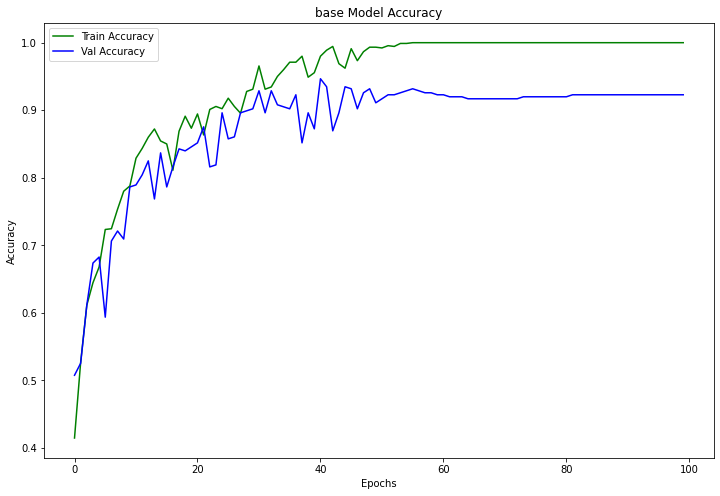

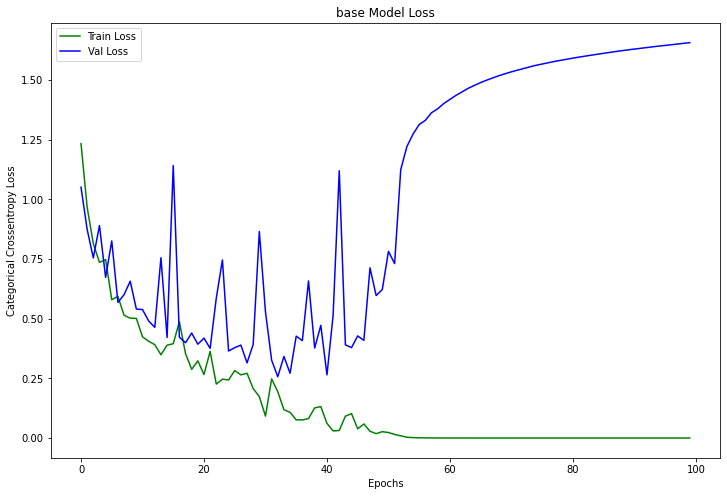

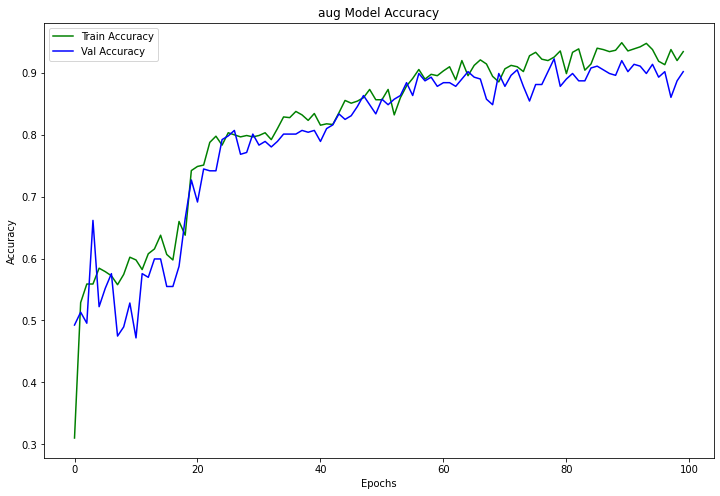

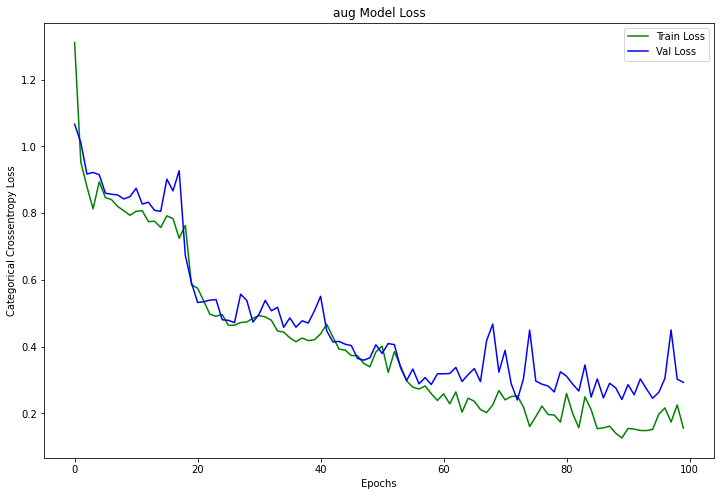

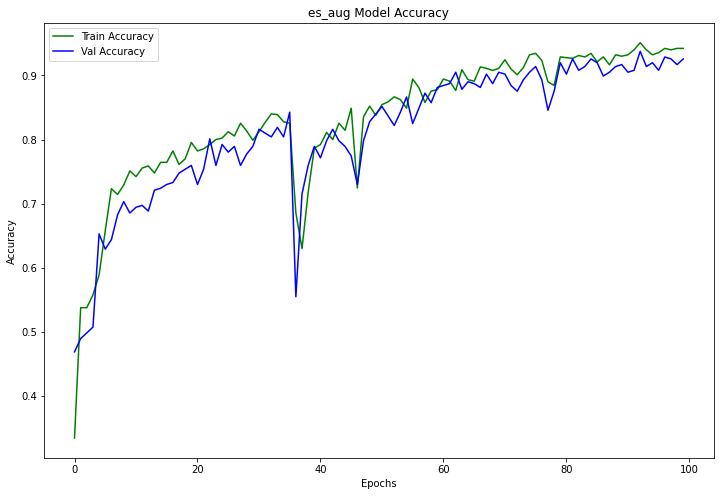

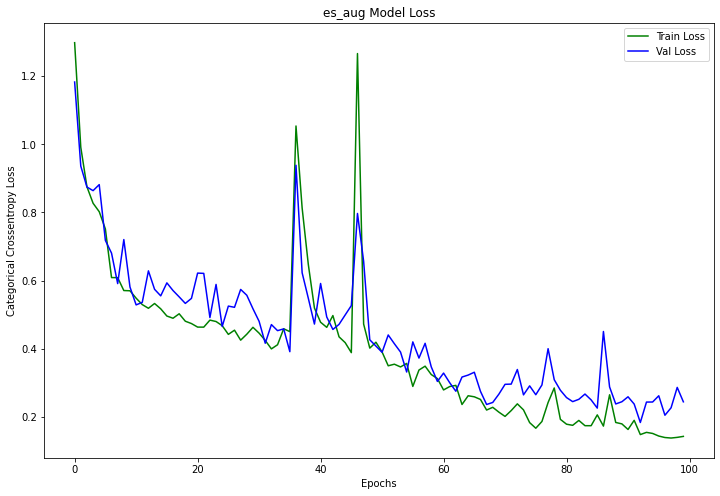

In [11]:
for name, history in model_history.items():
  plot_accuray(history, name)
  plot_loss(history, name)

In [12]:
for name, model in models.items():
  model.evaluate(val_ds)
  model.save_weights(f'./checkpoints/{name}/trained')

11/11 [==============================] - 0s 14ms/step - loss: 0.2447 - accuracy: 0.9258
